# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
sys.path.append("/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    if iteration_count % 30 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 1947.219045432261 [-0.68257214 -0.19520267 -0.36876662  0.97055367]
iteration 30 accepted 1637.0844027547803 [ 0.00543474  0.083873   -0.31282981  0.2357162 ]
iteration 60 accepted 1571.815673831633 [-0.0053434   0.1391554  -0.21343978  0.25612787]
iteration 90 accepted 1530.2383881322849 [ 0.00130488  0.17241211 -0.12431136  0.26088649]
iteration 120 accepted 1502.3859859795953 [-0.00635169  0.17639577 -0.07761065  0.24160782]
iteration 150 accepted 1486.293816268446 [ 0.00318602  0.22151077 -0.03656132  0.29455749]
iteration 180 accepted 1472.888686413224 [-0.01848648  0.24351397 -0.01983866  0.31551269]


In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

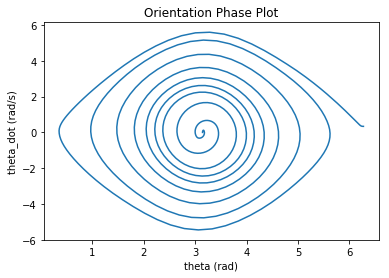

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")
plt.show()

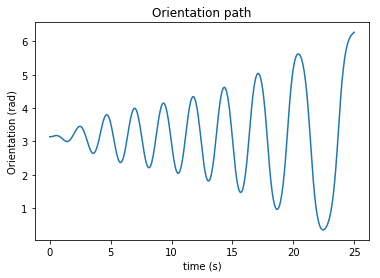

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

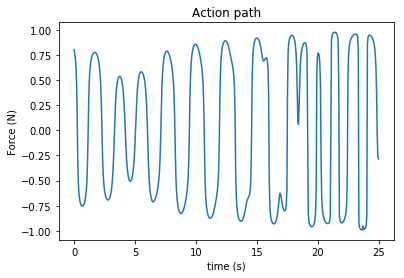

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

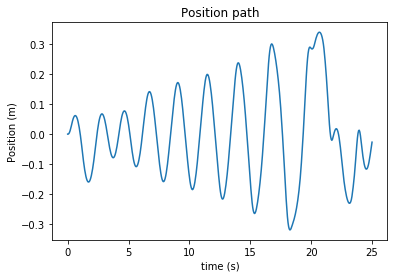

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

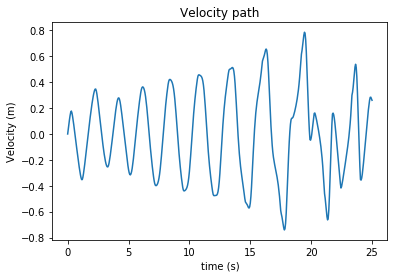

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

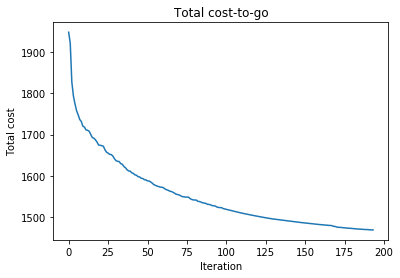

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

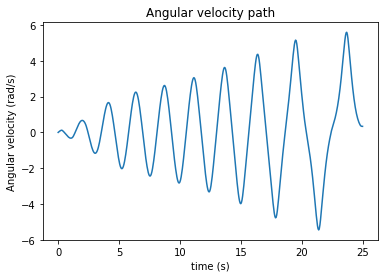

In [18]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

In [19]:
import gym

env = gym.make('CartPole-v0')

state = env.reset()
reward = 0.0
done = False

len_seq = 1
n = 200
n_iterations = 100
for step in range(int(200/len_seq)): 
    x0 = dynamics.augment_state(state)
    us_init = np.random.uniform(-1, 1, (n , dynamics.action_size))
    ilqr = iLQR(dynamics, cost, n)
    xs, us = ilqr.fit(x0, us_init, n_iterations = n_iterations, on_iteration=on_iteration)
    us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)
    us = us[0: len_seq]
    us = (us > 0.0).astype(int)
    for i_step in range(len_seq):
        u = us[i_step][0]
        print(step * len_seq + i_step, state, u, reward, done)
        state, reward, done, _ = env.step(u)
        env.render()
        if done is True:
            raise ValueError('Done')

iteration 0 accepted 4085.7128760005135 [-2.02775445 -0.023322   -0.72648528 -5.45682202]
iteration 30 accepted 1279.6045139285757 [-0.11668412 -0.02236865 -0.01043596 -3.04193488]
iteration 60 accepted 1244.319406066163 [-0.116232   -0.11311142 -0.04582848 -2.95058625]
0 [-0.03744017 -0.01351632 -0.03467637 -0.02380043] 1 0.0 False
iteration 0 accepted 2918.08876101371 [ 0.13972567  0.1513019  -0.86551494 -4.82540062]
iteration 30 accepted 1146.4331311138658 [-0.05066632 -0.05047733 -0.05704454 -2.80484087]
iteration 60 accepted 1132.6195917687155 [-0.12202273 -0.09445235 -0.05655668 -2.74958364]
1 [-0.03771049  0.18208532 -0.03515238 -0.32721932] 1 1.0 False
iteration 0 accepted 4935.484381780317 [ 1.19479356  0.446145   -0.37387391 -6.38857386]
iteration 30 accepted 1755.34819679023 [-0.08985903  0.05260254  0.05320199 -3.69161236]
2 [-0.03406879  0.37768964 -0.04169676 -0.63077721] 1 1.0 False
iteration 0 accepted 6507.454943572209 [ 0.84674436  0.51029663 -0.90654234 -6.59946495]


ValueError: Done